In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

<h1>Use <code>module load</code> to load preinstalled libraries</h1>

<p>Helpdesk has been a great help by setting up most of the deep learning libraries we could want.</p>
<p>On a Ubuntu machine, from the command line, type:</p>
<code>module avail</code>

<p>To see all that they installed. If you want to load <b>TensorFlow</b> with <b>Keras</b>, from the command line type,</p>
<code>module load TOOLS/TENSORFLOW/1.0-CPU-PY2713</code>
<p>If you have only want the CPU version.</p>

<p>If you want a GPU version, type</p>
<code>module load TOOLS/TENSORFLOW/1.0-GPU-PY2713</code>

<p>You can load the Python 3.5 versions if you prefer, but for this tutorial, we'll use Python 2.7 with the GPU version.</p>

<h1>A complete example of training a small CNN</h1>

<b>A simple complete example showing how to create a CNN for Keras using the CIFAR10 dataset.</b>

<p>We'll go through the following steps that are common to almost all problems:</p>
<ol>
<li>Spliting data into train, valid, and test</li>
<li>preprocessing images</li>
<li>setting up a typical CNN architecture</li>
<li>training the CNN</li>
<li>testing the CNN and reporting metrics</li> 
</ol>

<p><b>CNN architecture</b></p>
<p>The CNN has 5 layers and shows how to use,</p>
<ul>
<li>convolutional layers</li>
<li>fully-connected layers</li>
<li>max-pooling</li>
<li>batch normalization</li>
<li>dropout</li>
<li>weight regularization</li>
<li>SGD</li>
<li>a function to specify parts of repeated architecture</li>
</ul>

<p>This CNN is very small (only ~116K parameters), and achieves ~77% accuracy after 25 epochs (okay not great accuracy, but hey, this is just an example).</p>

<p>This takes < 15 mins to train for 25 epochs, using a 2GB NVIDIA GPU.</p>

In [2]:
from __future__ import print_function, division

<b>Technical note</b>
<p>I use Python 2.7 instead of the newer 3.X version... This is because, occasionally, there are times when only Python 2.7 is supported.</p>

<p>So this `from __future__` thing forces some parts of the code to behave like Python 3.X</p>

In [3]:
# Puts figure right into this notebook.
%matplotlib inline  
import matplotlib.pyplot as plt # So we can get matlab like plots.
import numpy as np # So we can treat things as a multi-dimensional array 
# Like how in MATLAB everything is a matrix. Numpy lets everything be an array.

# Numpy and matplotlib libraries can do a lot of the MATLAB functionality!

In [4]:
# A bunch of things to import from keras.
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dropout, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import AveragePooling2D
from keras import optimizers
from keras import initializers
from keras import regularizers

Using TensorFlow backend.


<h3>Keras versions</h3>
<p>This code was written for the Keras 2.0 version. This is important! They changed how some of the functions are called in Keras 2.0 vs earlier versions. So if you are getting strange erorrs, check your version of Keras!</p>

In [5]:
keras.__version__

'2.0.0'

<h2>Load and check out the data</h2>

In [6]:
from keras.datasets import cifar10 # Get an existing dataset.
# Download and load the data.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# 10 classes for cifar10.
nb_classes = 10

In [7]:
# Check our shapes.
print(X_train.shape) # 50K images of size 32 x 32 x 3 (tiny color images) <-- train
print(X_test.shape)  # 10K images to test.

print(y_train.shape) # 50K corresponding labels.
print(y_test.shape)  # 10K corresponding labels.

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


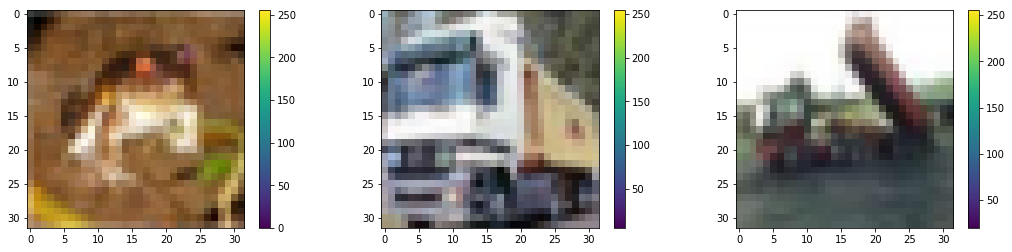

In [8]:
# Let's look at some figures...
plt.figure(figsize=(18,4))
plt.subplot(1,3,1); plt.imshow(X_train[0]); plt.colorbar(); # Pixel values range between 0-255.
plt.subplot(1,3,2); plt.imshow(X_train[1]); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(X_train[2]); plt.colorbar();

In [9]:
print(y_train[0]) # Frog category?
print(y_train[1]) # Frog category?
print(y_train[2]) # Truck category?

[6]
[9]
[9]


<h2>Preprocess the data</h2>

<p>We'll do some very simple preprocessing before we train our net</p>

<h3>Normalize to 1, and zero-mean images</h3>

In [10]:
# Convert to float datatype.
X_train = X_train.astype(np.float32)

# Normalize so the max value is 1.
X_train /= 255

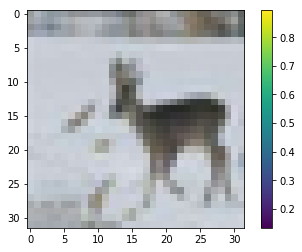

In [11]:
idx = 20
plt.imshow(X_train[idx,:,:]); plt.colorbar()

<h4>Note we are computing the mean pixel only over the training data!</h4>

In [12]:
# Subtract by the mean pixel, so image data is centered around 0.
mean_px = X_train.mean(axis=0).mean(axis=0).mean(axis=0)
print(mean_px)
X_train -= mean_px

[ 0.49139959  0.48215833  0.44653207]


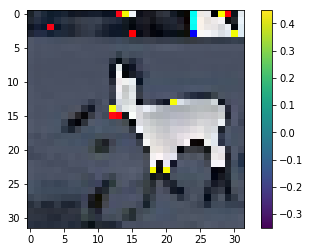

In [13]:
# Looks odd now since it's centered around 0.
idx = 20
plt.imshow(X_train[idx,:,:]); plt.colorbar()

In [14]:
# Change to 1-hot encoding.
Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)

<p>`Y_train` (captial Y) has a 1 at the 6th element, and 0's everywhere else. This corresponds to the 6 in y_train.</p>
<p>Note that python is 0-indexed. This means we count starting from 0, not 1 (MATLAB counts from 1)</p>
<p>So the below example is the 6th position in Python, but the 7th position in MATLAB (important if you're moving data between both)</p>

In [15]:
print(y_train[0])
print(Y_train[0])

[6]
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


<h1>Setup the model</h1>

<h2>How to initialize the weights is important!</h2>

<p>There are many ways to do this... Most sample from some random initialization around 0.</p>
<p>But from what distribution (usually Gaussian or uniform)?</p>
<p>And with what standard deviation?</p>
<p>A common way, especially when using ReLUs, is to use the intialization proposed by He et al.</p>

<p>
He, K., Zhang, X., Ren, S., & Sun, J. (2016). 
Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. 
In ICCV (pp. 1026–1034). 
http://doi.org/10.1109/ICCV.2015.123
</p>

In [16]:
# Initialize the weights using He et al.'s approach.
kernel_init = initializers.he_uniform()

In [17]:
# `kernel_init` is a function that we can pass around.
out = kernel_init(shape=(5,5))

In [18]:
# If we try and just see the values of `out`, we get this odd message. 
# That's because it returns a Tensor. 
print(out)

Tensor("random_uniform:0", shape=(5, 5), dtype=float32)


In [19]:
# We actually have to evaluate the tensor to view the values.
print(K.eval(out))

[[ 0.77371919 -0.39911532 -0.42955834 -0.79232579 -0.66041124]
 [-0.3162601   0.79411197 -0.11525524  0.91366434  0.91579008]
 [ 0.11419308 -0.23065233 -0.86410779  0.76637423 -0.07251906]
 [ 0.03926659  0.03180087 -1.06965029 -1.09209275  0.168643  ]
 [ 0.04060161 -0.8459577   0.02459896  1.06020045 -0.78513044]]


<h2>Weight regularization</h2>

<p>In order to prevent our learned weights from becoming too large, we will penalize large weights (encourage them to be small)</p>

In [20]:
# Function to regularize the 
reg = regularizers.l2(l=0.0005)

In [21]:
# So what does this mean? reg() is a function.
# We return the l2 norm of the input weighed by `l`.
# So 0.0005*1^2 = 0.0005
out = reg(1.)
print(K.eval(out))

0.0005


In [22]:
0.0005*(3**2)

0.0045000000000000005

In [23]:
out = reg(3.)
print(K.eval(out))

0.0045


<h2>Clearing the graphs from the GPU memory</h2>

<p>This clears the session's graph. That is all the stuff that's been stored in TensorFlow. 
Run this to clear all the stuff on the GPU.</p>

<p>This is very useful if you're running some cross-validation models, or testing different models.
You'll quickly get out of memory errors. Run this, and re-create your graphs, to avoid having to restart your kernel. </p>

<p>So if you run the below example, and then wanted to re-run it, you should run this `K.clear_session()` to clear the GPU memory, and start again</p>

In [24]:
# Clear the tensorflow graphs on the GPU memory.
K.clear_session()

<h2>Network architecture</h2>
<h3>Using a function to specify repeated layers</h3>
<p>Here we use a function to do a convolution, batch normalization, and apply a rectified linear unit.</p>
<p>It can be handy to use these functions if your network architecture repeats itself.</p>

In [25]:
def conv_bn_relu(x, # The previous layer.
                 filters, # How many filters to use.
                 kernel_size=(3,3) # Spatial dimensions of the filter.
                ):
    
    # This is a 2D convolutional layer.
    x = Conv2D(filters, # How many filters (number of output feature maps)
               kernel_size=kernel_size, # Spatial dimensions of the kernel (sliding window)
               padding='same', # How to deal with the border values (or 'valid')
               kernel_initializer=kernel_init, # How to initialize the weights (defined earlier)
               kernel_regularizer=reg # How to regularize the weights (defined earlier)
              )(x) # Input to this layer.
    
    # Normalizes the layers. 
    # http://proceedings.mlr.press/v37/ioffe15.html
    x = BatchNormalization()(x)
    
    # Non-linear activation function.
    # Leaky Rectified Linear Unit.
    x = LeakyReLU(0.33)(x)
    
    # Return the layer 
    return x

In [26]:
# In case you want to read the documentation, or see what parameters there are, you can do this.
#?Conv2D

In [27]:
# We specifiy the input. Our images are 32 x 32 spatial pixels by 3 colour channels.
inputs = Input(shape=(32, 32, 3))

In [28]:
# Apply the convolutional, batch norm, and relu function to the input. 
# Create 64 feature maps/filters.
# Use filters of spatial size 3x3.
x = conv_bn_relu(inputs, 64, kernel_size=(3,3))

# Max-pool the layers (take the maximium response) within a 2x2 window.
# Move the window a stride over by 2x2 pixels.
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

In [29]:
# Repeat this 3 more times.
# These are all convolutions, followed by max-pooling layers.
x = conv_bn_relu(x, 64, kernel_size=(3,3))
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

x = conv_bn_relu(x, 64, kernel_size=(3,3))
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

x = conv_bn_relu(x, 64, kernel_size=(3,3))
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

In [30]:
# This vectorizes the input (no spatial dimensions, a single long feature vector)
x = Flatten()(x)
# Add dropout with a rate of 0.5 (set half the layer responses to 0)
x = Dropout(0.5)(x)

In [31]:
# Create a fully connected layer with 256 feature maps/filters.
#x = Dense(256, kernel_initializer=kernel_init)(x)
#x = BatchNormalization()(x)
# Add a non-linear activation function.
#x = LeakyReLU(0.33)(x)
# Add dropout with a rate of 0.5 (set half the layer responses to 0)
#x = Dropout(0.5)(x)

In [32]:
# The output layer. This creates 10 nodes, one for each class.
# We add a softmax activation function to this layer since
# we want to scale the outputs between 0 and 1 (which a softmax does).
preds = Dense(nb_classes, kernel_initializer=kernel_init, activation='softmax')(x)

In [33]:
print(nb_classes) # 10 classes = 10 nodes.

10


In [34]:
# Now we finally create the model here.
# We specify the inputs, and the outputs. 
# Note we can handle multiple inputs and outputs if needed.
model = Model(inputs=inputs, outputs=[preds])

In [35]:
# Now let's look at the model. Does this make sense?
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
__________

In [36]:
sgd = optimizers.SGD(lr=0.01, # Learning rate: probably the most important hyper-parameter to tune!
                              # Try 0.01, if loss does not go down, or if it goes to NaN, 
                              # try 0.001, then 0.0001, then 0.00001, 
                              # This can really make a big difference!
                     decay=1e-6, # A common training strateg is to lower the learning rate over epochs.
                                 # This is how much to lower the learning rate.
                     momentum=0.9, # Gather velocity in the gradient update.
                                   # (helps converge, get out of flat areas/local mins)
                     nesterov=True) # Use the gradients from the previous mini-batches 
                                    # (helps converge, get out of flat areas/local mins)

In [37]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy', # The function to optimize. This will determine everything!
              metrics=['accuracy']) # What metrics to report during training.

<h1>Train the model</h1>

<h3>Initial goal: lower the training loss</h3>
<p>To start, you should be most interested in if your training loss is going down over epochs. You want to see a clear trend where the training loss decreases. It should decrease quite quickly in the first few epochs, then slower over time.</p>

<p>This should be your main focus at the start. If the training loss is not decreasing, then you probably have a problem with your network somewhere (even if your data is composed of random noise, a large enough network should be able to lower the loss over the dataset just by memorizing the training data).</p>

<p>If the loss is not decreasing, you should look at (in suggested order):</p>
<ul>
<li>lower the learning rate (by a factor of ten, a few times e.g., 0.01, 0.001, 0.0001, 0.00001)</li>
<li>remove regularization (no dropout, no l2-weight regularization)</li>
<li>make sure the output layer and loss function are setup correctly and makes sense for your problem</li>
<li>check how the data is preprocessed and make sure it's not garbled</li>
<li>check your weight initializations</li>
<li>make the layers wider (i.e., more nodes in a hidden layer, not deeper)</li>
</ul>

<p>Note: adding batch normalization often seems to make the training easier. So it's often good to have these layers.</p>

In [38]:
model.fit(X_train, # The data (what we observe, the images)
          [Y_train], #  The labels (what we want to predict)
          batch_size=32,  # 32 images are going through the net (update based on 32 images). 
                          # If you get out-of-memory errors, try lowering the batch_size.
          epochs=25,  # epoch = full pass over the training data.
          validation_split=0.2, # Shuffle 
          shuffle=True, # Shuffle the training data each 
          verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/25
30s - loss: 1.7426 - acc: 0.4718 - val_loss: 1.3721 - val_acc: 0.6002
Epoch 2/25
29s - loss: 1.3251 - acc: 0.6108 - val_loss: 1.2006 - val_acc: 0.6521
Epoch 3/25
29s - loss: 1.1784 - acc: 0.6578 - val_loss: 1.1047 - val_acc: 0.6819
Epoch 4/25
29s - loss: 1.0934 - acc: 0.6874 - val_loss: 1.0995 - val_acc: 0.6838
Epoch 5/25
29s - loss: 1.0338 - acc: 0.7093 - val_loss: 1.0690 - val_acc: 0.6882
Epoch 6/25
29s - loss: 0.9857 - acc: 0.7232 - val_loss: 1.1089 - val_acc: 0.6887
Epoch 7/25
29s - loss: 0.9497 - acc: 0.7378 - val_loss: 0.9422 - val_acc: 0.7479
Epoch 8/25
29s - loss: 0.9364 - acc: 0.7409 - val_loss: 0.9797 - val_acc: 0.7267
Epoch 9/25
30s - loss: 0.9127 - acc: 0.7536 - val_loss: 1.0108 - val_acc: 0.7195
Epoch 10/25
29s - loss: 0.8972 - acc: 0.7587 - val_loss: 0.9386 - val_acc: 0.7480
Epoch 11/25
29s - loss: 0.8840 - acc: 0.7659 - val_loss: 0.9108 - val_acc: 0.7612
Epoch 12/25
29s - loss: 0.8722 - acc: 0.7715 - val_loss: 

<h3>Secondary goal: Make sure you don't overfit!</h3>
<ul>
<li>Monitor your validate loss and if training loss is way lower, you've probably overfit</li>
<li>If your valid accuracy is way lower than training accuracy, you've probably overfit</li>
</ul>

<p>If you've overfit</p>
<ul>
<li>Terminate training earlier (train on less epochs)</li>
<li>More dropout</li>
<li>Data augmentation</li>
</ul>

<h1>Save and load your model</h1>

In [39]:
model.save('cifar10_model.h5')  # Creates a HDF5 file to save the weights and architecture to.
del model  # deletes the existing model

In [40]:
model # See? It's gone.

NameError: name 'model' is not defined

In [41]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('final_cifar10_model.h5')

<h1>Test your model!</h1>
<p>Take the model you found performed best over your <b>valid set</b> and you're now ready to use it over your <b>test set</b></p>

<h3>Preprocess test set</h3>

In [42]:
# Make sure you apply the extact same pre-preprocessing procedure to your 
# test set, as you did to the train set.

X_test = X_test.astype(np.float32) # Make a float.
X_test /= 255 # Max value = 1.
X_test -= mean_px # Computed over the train set.

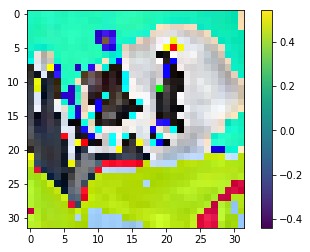

In [43]:
plt.imshow(X_test[0]); plt.colorbar()

In [44]:
# Predict!
test_probs = model.predict(X_test)

In [45]:
print(test_probs.shape) # 10K samples, with 10 classes. A probability for each class.

(10000, 10)


In [50]:
# We get probabilities like this.... (1 of k)
test_probs[2]

array([  8.59790146e-02,   1.68978609e-02,   1.61032134e-03,
         4.04329645e-03,   7.90514576e-04,   2.02895899e-04,
         1.02927221e-03,   1.21997343e-03,   7.61652470e-01,
         1.26574397e-01], dtype=float32)

In [51]:
# But we want to go back to the numbers as in the ground truth!
print(y_test[2])
print(y_test.shape)

[8]
(10000, 1)


In [52]:
# Get the index for the largest probability (argmax) over the class axis.
test_preds = np.argmax(test_probs,axis=1)

In [53]:
print(test_preds.shape) # Now we have 10K single class labels.

(10000,)


In [54]:
print(test_preds[2]) # See, it's no longer 1-of-k encoded

8


In [55]:
# We compute the accuracy over the test set! 
acc = np.mean(test_preds == np.squeeze(y_test))
print(acc)

0.7679


In [117]:
# And we're done!